## Starting
- loading data
- move to torch

In [5]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)


In [6]:
import torch
from torch import nn

xtrain = torch.Tensor(X_train).float()
ytrain = nn.functional.one_hot(torch.Tensor(y_train).long())
xtest = torch.Tensor(X_test).float()
ytest = nn.functional.one_hot(torch.Tensor(y_test).long())


## Plotting function

In [7]:
import matplotlib.pyplot as plt
import numpy as np
def PlotBoundries(x_arr, y_arr, model):
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 1, 1)
    plt.plot(x_arr[y_arr==1,0], x_arr[y_arr==1,1], 'o', color='red', label='class 1')
    plt.plot(x_arr[y_arr==0,0], x_arr[y_arr==0,1], 'o', color='blue', label='class 0')
    x1 = np.linspace(-2, 3, 100)
    x2 = np.linspace(-2, 2, 100)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.stack([X1.reshape(-1), X2.reshape(-1)], axis=1)
    X = torch.Tensor(X).float()
    cmap = plt.get_cmap('bwr')
    try : 
        y_pred = model(X).argmax(dim=1).reshape(X1.shape)
    except :
        y_pred = model.forward(X).argmax(dim=1).reshape(X1.shape)
    plt.contourf(X1, X2, y_pred, alpha=0.3, cmap=cmap)
    plt.legend()
    plt.show()
    


## Create Model
## Model 1 - Linear
- input shape : (800, 2)
- 1st layer : (800, 2) -> (800, 20)
  - weights -> 2, 20, b -> 20
  - activation -> linear
- 2nd layer -> (800,20) -> (800, 40)
  - weights -> 20, 40, b -> 40
  - activation -> linear
- 3d layer -> (800, 40) -> (800, 2)
  - weights -> 40, 2, b -> 2
  - activation -> linear
- output shape : (800, 2)
  - sigmoid
$$
\sigma{(x)} = \frac{1}{1 + e^{-x}}

In [54]:
def sigmoidfn(x):
    return 1 / (1 + torch.exp(-x))

def accuracy(y_true, y_pred):
    return (y_pred.argmax(dim=1) == y_true.argmax(dim=1)).float().mean()


def CrossEntropy(y_true, y_pred):
    return torch.mean(-(y_true * torch.log(y_pred)).sum(dim=1))

In [55]:
class LinearLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = torch.randn(output_dim, input_dim, requires_grad=True) * 0.1
        self.weights.retain_grad()
        self.bias = torch.zeros(output_dim, requires_grad=True)
        self.bias.retain_grad()

    def forward(self, input):
        return input @ self.weights.t() + self.bias

class LinearModel:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.linear1 = LinearLayer(input_dim, hidden_dim)
        self.linear2 = LinearLayer(hidden_dim, hidden_dim*2)
        self.linear3 = LinearLayer(hidden_dim*2, output_dim)
        self.sigmoid = sigmoidfn

    def forward(self, input):
        l1 = self.linear1.forward(input)
        l2 = self.linear2.forward(l1)
        l3 = self.linear3.forward(l2)
        out =  self.sigmoid(l3)
        return out
    
EPOCH = 1000
LR = 0.01
linear_model = LinearModel(2, 20, 2)



In [56]:

for epoch in range(EPOCH):
    ypred = linear_model.forward(xtrain)
    loss = CrossEntropy(ytrain, ypred)
    loss.backward(retain_graph=True)
    with torch.no_grad():
        # * update weights
        linear_model.linear1.weights -= LR * linear_model.linear1.weights.grad
        linear_model.linear1.bias -= LR * linear_model.linear1.bias.grad
        linear_model.linear2.weights -= LR * linear_model.linear2.weights.grad
        linear_model.linear2.bias -= LR * linear_model.linear2.bias.grad
        linear_model.linear3.weights -= LR * linear_model.linear3.weights.grad
        linear_model.linear3.bias -= LR * linear_model.linear3.bias.grad
        # * zero the gradients
        linear_model.linear1.weights.grad.zero_()
        linear_model.linear1.bias.grad.zero_()
        linear_model.linear2.weights.grad.zero_()
        linear_model.linear2.bias.grad.zero_()
        linear_model.linear3.weights.grad.zero_()
        linear_model.linear3.bias.grad.zero_()

        # * print loss
        if epoch % (EPOCH // 10) == 0:
            print(f"Epoch: {epoch}, Loss: {loss} | Accuracy: {accuracy(ytrain, ypred)}")

Epoch: 0, Loss: 0.7020633220672607 | Accuracy: 0.2524999976158142
Epoch: 100, Loss: 0.5276179909706116 | Accuracy: 0.5
Epoch: 200, Loss: 0.3941931426525116 | Accuracy: 0.5
Epoch: 300, Loss: 0.28673702478408813 | Accuracy: 0.5249999761581421
Epoch: 400, Loss: 0.2033151239156723 | Accuracy: 0.6549999713897705
Epoch: 500, Loss: 0.14302818477153778 | Accuracy: 0.7350000143051147
Epoch: 600, Loss: 0.10192885994911194 | Accuracy: 0.7674999833106995
Epoch: 700, Loss: 0.07457943260669708 | Accuracy: 0.7862499952316284
Epoch: 800, Loss: 0.056285642087459564 | Accuracy: 0.7950000166893005
Epoch: 900, Loss: 0.0437813326716423 | Accuracy: 0.800000011920929


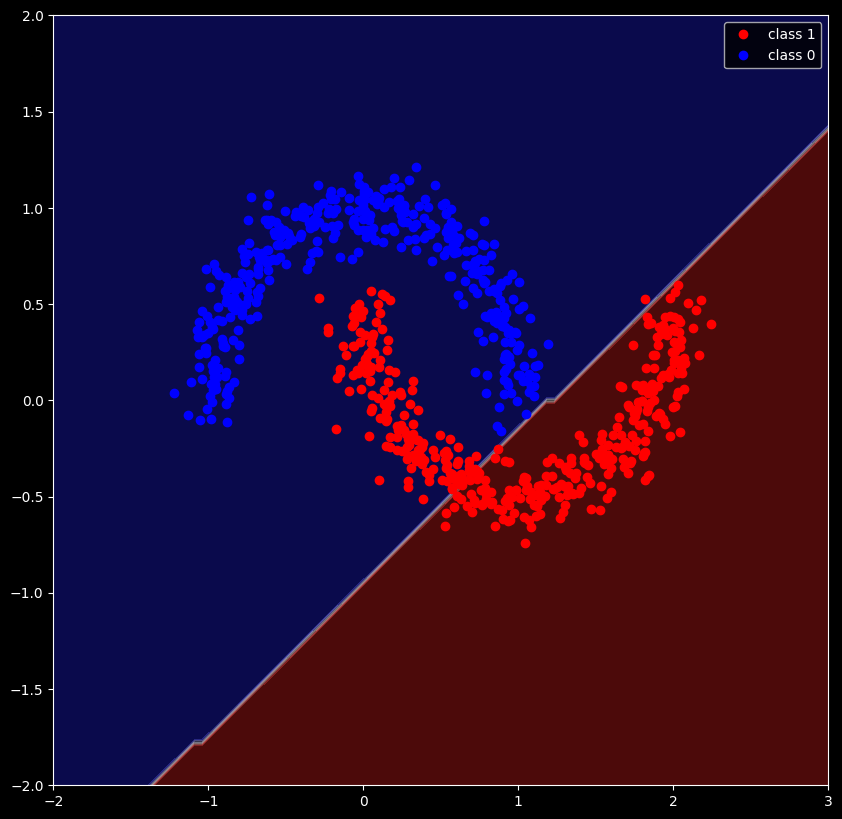

In [57]:
PlotBoundries(X_train, y_train, linear_model)

In [58]:
def relu(x):
    #* compare between x value and torch full of zeros
    return torch.max(torch.zeros_like(x), x) 

class NonLinear:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.linear1 = LinearLayer(input_dim, hidden_dim)
        self.linear2 = LinearLayer(hidden_dim, hidden_dim*5)
        self.linear3 = LinearLayer(hidden_dim*5, hidden_dim*10)
        self.linear4 = LinearLayer(hidden_dim*10, output_dim)
        self.sigmoid = sigmoidfn
        self.relu = relu
    
    def forward(self, input):
        l1 = self.linear1.forward(input)
        l1 = self.relu(l1)
        l2 = self.linear2.forward(l1)
        l2 = self.relu(l2)
        l3 = self.linear3.forward(l2)
        l3 = self.relu(l3)
        l4 = self.linear4.forward(l3)
        out =  self.sigmoid(l4)
        return out

In [61]:
EPOCH = 500
LR = 0.5
model = NonLinear(2, 50, 2)
ytrain = ytrain.float()
for epoch in range(EPOCH):
    ypred = model.forward(xtrain).float()
    #* there's something wrong with the loss function that DR. Mina gave us
    #* Uncomment the line below to use the loss function and check it yourself
    # loss = CrossEntropy(ytrain.float(), ypred.float())
    
    loss = nn.CrossEntropyLoss()(ypred, ytrain)
    loss.backward(retain_graph=True)
    with torch.no_grad():
        # * update weights
        model.linear1.weights -= LR * model.linear1.weights.grad
        model.linear1.bias -= LR * model.linear1.bias.grad
        model.linear2.weights -= LR * model.linear2.weights.grad
        model.linear2.bias -= LR * model.linear2.bias.grad
        model.linear3.weights -= LR * model.linear3.weights.grad
        model.linear3.bias -= LR * model.linear3.bias.grad
        model.linear4.weights -= LR * model.linear4.weights.grad
        model.linear4.bias -= LR * model.linear4.bias.grad
        # * zero the gradients
        model.linear1.weights.grad.zero_()
        model.linear1.bias.grad.zero_()
        model.linear2.weights.grad.zero_()
        model.linear2.bias.grad.zero_()
        model.linear3.weights.grad.zero_()
        model.linear3.bias.grad.zero_()
        model.linear4.weights.grad.zero_()
        model.linear4.bias.grad.zero_()

        # * print loss
        if epoch % (EPOCH // 10) == 0 or epoch == EPOCH-1:
            print(f"Epoch: {epoch}, Loss: {loss} | Accuracy: {accuracy(ytrain, ypred)}")

Epoch: 0, Loss: 0.6973626613616943 | Accuracy: 0.5
Epoch: 50, Loss: 0.42225930094718933 | Accuracy: 0.8949999809265137
Epoch: 100, Loss: 0.40809518098831177 | Accuracy: 0.9087499976158142
Epoch: 150, Loss: 0.39773327112197876 | Accuracy: 0.9150000214576721
Epoch: 200, Loss: 0.3731606602668762 | Accuracy: 0.9424999952316284
Epoch: 250, Loss: 0.33984678983688354 | Accuracy: 0.9887499809265137
Epoch: 300, Loss: 0.3247746229171753 | Accuracy: 0.9962499737739563
Epoch: 350, Loss: 0.3207555413246155 | Accuracy: 0.9987499713897705
Epoch: 400, Loss: 0.31877055764198303 | Accuracy: 0.9987499713897705
Epoch: 450, Loss: 0.317594438791275 | Accuracy: 1.0
Epoch: 499, Loss: 0.31679919362068176 | Accuracy: 1.0


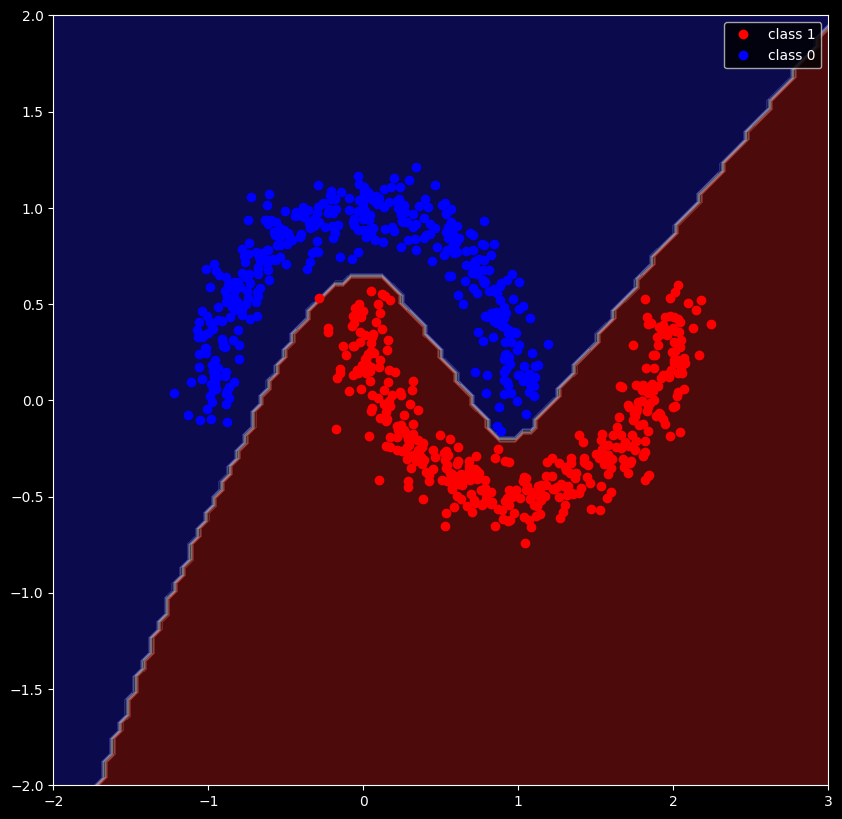

In [62]:
PlotBoundries(X_train, y_train, model)

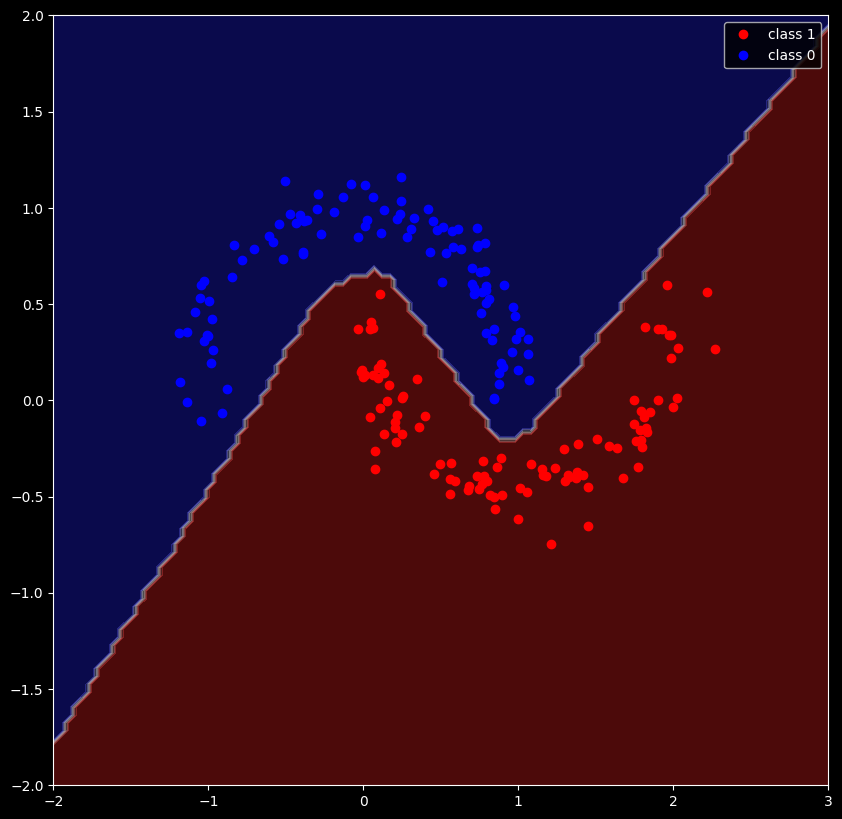

In [52]:
PlotBoundries(X_test, y_test, model)

In [15]:
class testmode(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim*4)
        self.linear3 = nn.Linear(hidden_dim*4, out_dim)
        self.relu = nn.ReLU()
        self.sig = nn.Softmax(dim=1)
        
    def forward(self, input):
        l1 = self.linear1(input)
        r1 = self.relu(l1)
        l2 = self.linear2(r1)
        r2 = self.relu(l2)
        l3 = self.linear3(r2)
        # out =  nn.functional.softmax(l3, dim=1)
        
        return self.sig(l3)
    
model2  = testmode(2, 100, 2)
nnloss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.05)


In [16]:
for epoch in range(EPOCH):
    ypred = model2(xtrain)
    loss = nnloss(ytrain.float(), ypred.float())
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    with torch.no_grad():
        # * print loss
        if epoch % (EPOCH // 10) == 0 or epoch == EPOCH-1:
            print(f"Epoch: {epoch}, Loss: {loss} | Accuracy: {accuracy(ytrain, ypred)}")
            

Epoch: 0, Loss: 0.8121085166931152 | Accuracy: 0.5
Epoch: 250, Loss: 0.4462672472000122 | Accuracy: 0.8799999952316284
Epoch: 500, Loss: 0.42344170808792114 | Accuracy: 0.9100000262260437
Epoch: 750, Loss: 0.4079488515853882 | Accuracy: 0.9225000143051147
Epoch: 1000, Loss: 0.3936707377433777 | Accuracy: 0.9300000071525574
Epoch: 1250, Loss: 0.3778028190135956 | Accuracy: 0.949999988079071
Epoch: 1500, Loss: 0.3594859838485718 | Accuracy: 0.9712499976158142
Epoch: 1750, Loss: 0.34351739287376404 | Accuracy: 0.9887499809265137
Epoch: 2000, Loss: 0.33414122462272644 | Accuracy: 0.9950000047683716
Epoch: 2250, Loss: 0.3287999629974365 | Accuracy: 0.9962499737739563
Epoch: 2499, Loss: 0.32553404569625854 | Accuracy: 0.9975000023841858


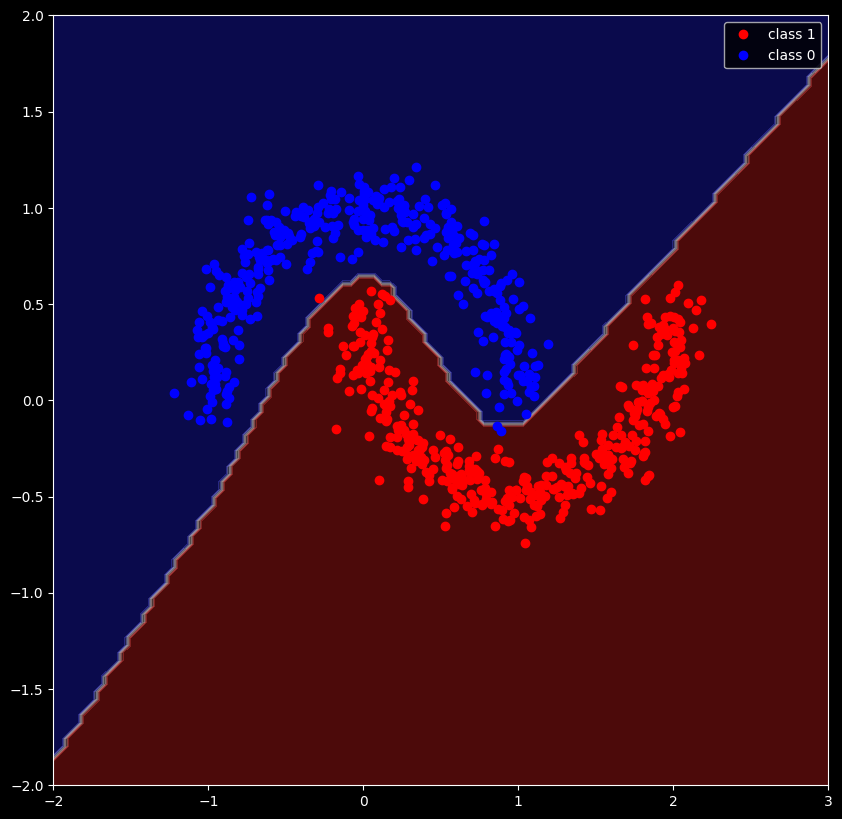

In [17]:
PlotBoundries(X_train, y_train, model2)